### Importing Required packages

In [1]:
import requests, pandas as pd, numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import arma_order_select_ic
import itertools
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf


C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Read the data

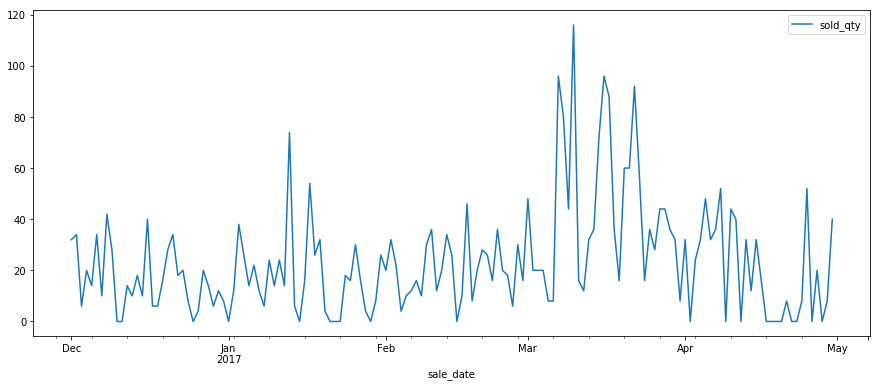

In [2]:
item_df=pd.read_csv('item_sales.csv',parse_dates=True,index_col='sale_date')

item_df.plot()

## Define function to check stationarity

In [3]:
def test_stationarity(series):
    
    #rolling mean
    rmean=series.rolling(window=7,center=False).mean()
    rstd=series.rolling(window=7,center=False).std()
    
    #plot statistics
    orig = plt.plot(series, color='blue',label='Original')
    mean = plt.plot(rmean, color='red', label='Rolling Mean')
    std = plt.plot(rstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Perform stationarity check on the series of values

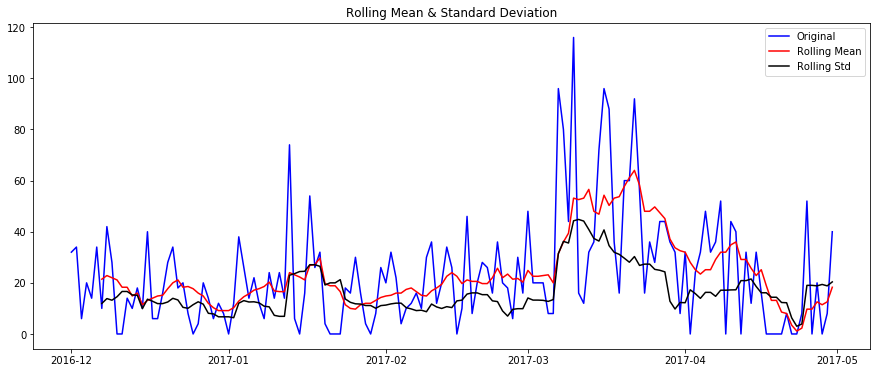

Results of Dickey-Fuller Test:
Test Statistic                  -1.892149
p-value                          0.335763
#Lags Used                       6.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [4]:
test_stationarity(item_df['sold_qty'])

Results show that series is not stationary and hence we will differentiate to make it stationary

In [5]:
tseries=item_df['sold_qty']
tseries_diff=tseries-tseries.shift()

Check stationarity after first order differentiation

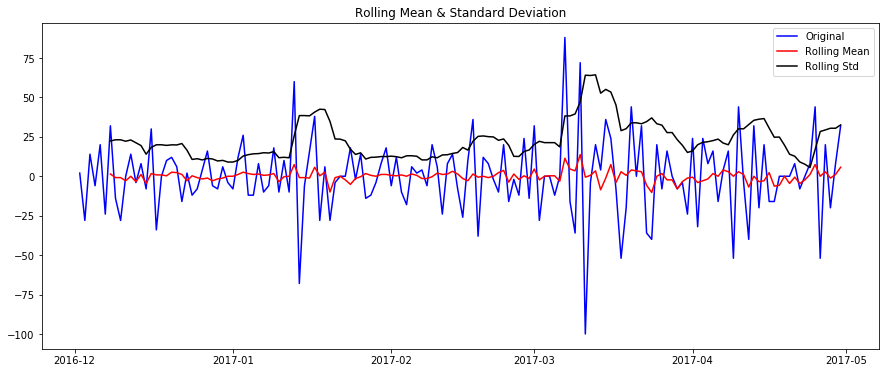

Results of Dickey-Fuller Test:
Test Statistic                -1.053852e+01
p-value                        8.772427e-19
#Lags Used                     5.000000e+00
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64


In [6]:
tseries_diff.dropna(inplace=True)
test_stationarity(tseries_diff)

## Results show that series is almost stationary

## Plot ACF and PACF for p,q parameters

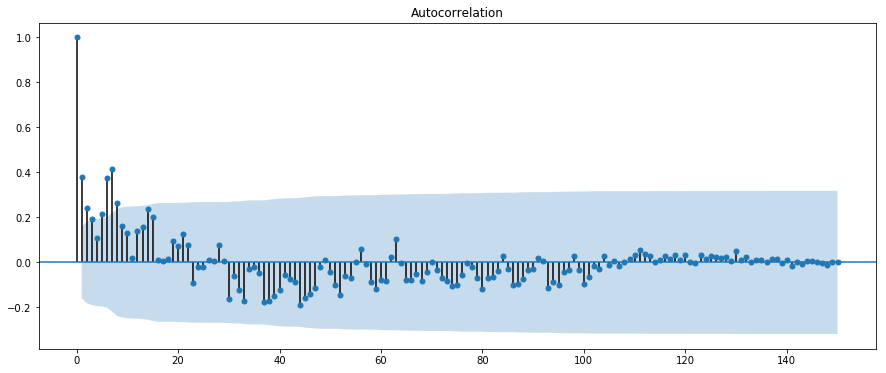

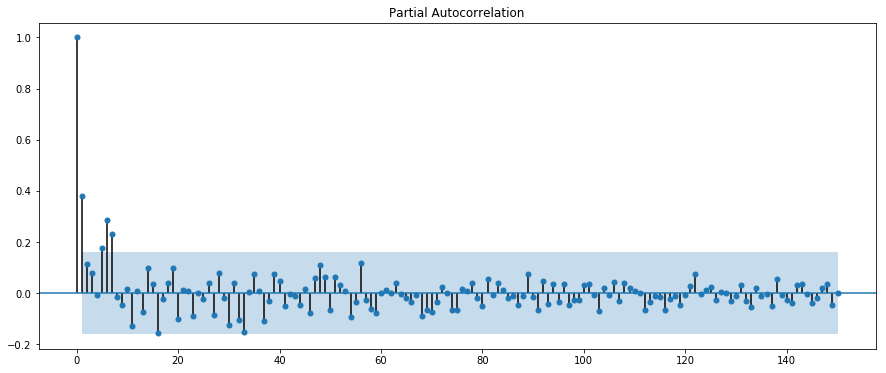

In [10]:
plot_acf(tseries)

plot_pacf(tseries)
pyplot.show()

Fit the model

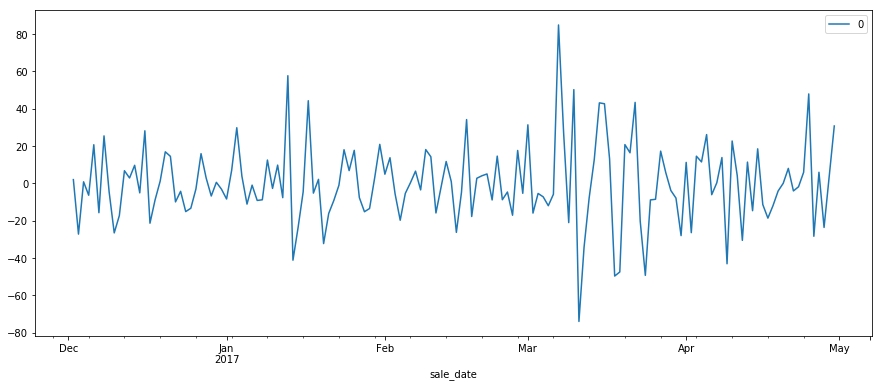

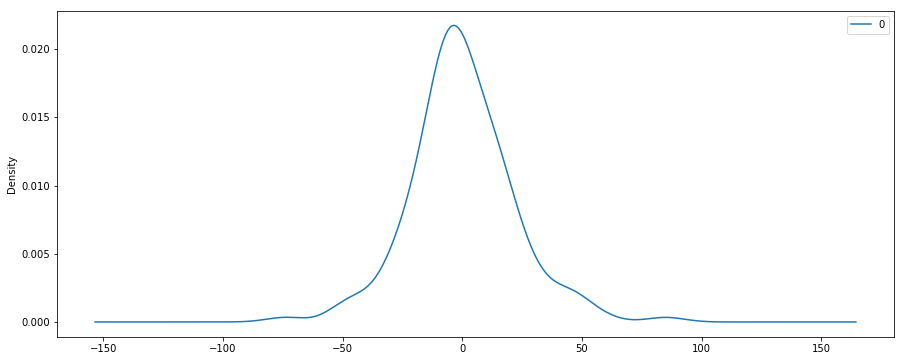

                0
count  150.000000
mean    -0.039508
std     21.563278
min    -74.020686
25%    -10.808734
50%     -2.426575
75%     12.325616
max     84.937666


In [11]:
model=ARIMA(tseries.astype(float),order=(2,1,0)).fit(disp=0)

residuals = pd.DataFrame(model.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

## Splitting data into test and train sets for predicting and the checking accuracy with test set

In [12]:
X = tseries.values
size = int(len(X) * 0.67)
size

train, test = X[0:size], X[size:len(X)]

### Performing one step forecast

predicted=55.889052, expected=12.000000
predicted=50.594459, expected=32.000000
predicted=22.211759, expected=36.000000
predicted=27.455332, expected=72.000000
predicted=52.105860, expected=96.000000
predicted=74.699370, expected=88.000000
predicted=86.383518, expected=36.000000
predicted=64.307679, expected=16.000000
predicted=38.621944, expected=60.000000
predicted=46.067686, expected=60.000000
predicted=47.651358, expected=92.000000
predicted=78.924219, expected=56.000000
predicted=64.304963, expected=16.000000
predicted=43.024918, expected=36.000000
predicted=38.485291, expected=28.000000
predicted=26.084251, expected=44.000000
predicted=39.497182, expected=44.000000
predicted=40.050856, expected=36.000000
predicted=39.509879, expected=32.000000
predicted=35.839335, expected=8.000000
predicted=18.843916, expected=32.000000
predicted=28.048969, expected=0.000000
predicted=7.418049, expected=24.000000
predicted=21.345672, expected=32.000000
predicted=22.475335, expected=48.000000
pre

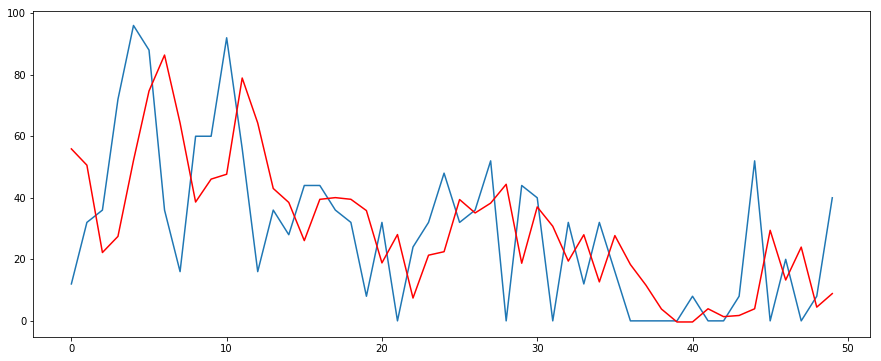

In [13]:
history = [x for x in train.astype(float)]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### We got 